## Импорт библиотек

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Просмотр данных

In [2]:
fish_df = pd.read_csv('Fish.csv', sep=',')

In [3]:
fish_df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [18]:
categories = fish_df.Species.unique()
categories

array(['Bream', 'Roach', 'Whitefish', 'Parkki', 'Perch', 'Pike', 'Smelt'],
      dtype=object)

In [5]:
fish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


Проущенных данных нет, значит предварительную предобработку можно не проводить

## Деление на тренировочную и тестовую подвыборки

In [272]:
X = fish_df.drop('Weight', axis=1).values
y = fish_df.Weight.values

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X[:, 0])

In [246]:
X_train.shape, y_train.shape

((127, 6), (127,))

In [226]:
X_test.shape, y_test.shape

((32, 6), (32,))

В делении использовался параметр stratify по виду рыбы для получения одинакового процентного содержания групп в подвыборках

<AxesSubplot:ylabel='count'>

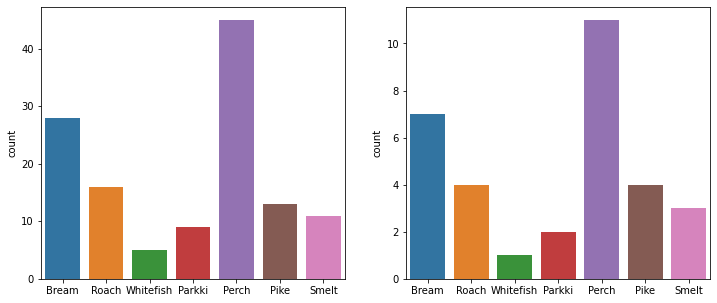

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=X_train[:, 0], order=categories, ax=axes[0])
sns.countplot(x=X_test[:, 0], order=categories, ax=axes[1])

Дисбаланс классов может повлиять на результаты модели

## Визуализация данных

In [64]:
train_dict = dict()

train_dict['Species'] = X_train[:, 0]
for index, key in enumerate(fish_df.columns[2:]): 
    train_dict[key] = X_train[:, index+1]
train_dict['Weight'] = y_train

train_df = pd.DataFrame(train_dict)

for column_name in train_df.columns[1:]:
    train_df[column_name] = train_df[column_name].astype("float32")

Text(0, 0.5, 'Характеристика длины, см')

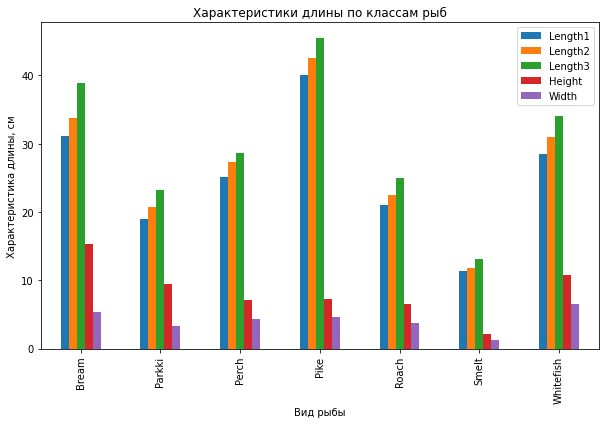

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
train_df.groupby('Species')[train_df.columns[1:-1]].agg('median').plot(kind='bar', ax=ax)
ax.set_title('Характеристики длины по классам рыб')
ax.set_xlabel('Вид рыбы')
ax.set_ylabel('Характеристика длины, см')

Можно увидеть, что различные виды рыб имеют отличающиеся характеристики, то есть классы хорошо отличаются друг от друга.

Text(0, 0.5, 'Вид рыбы')

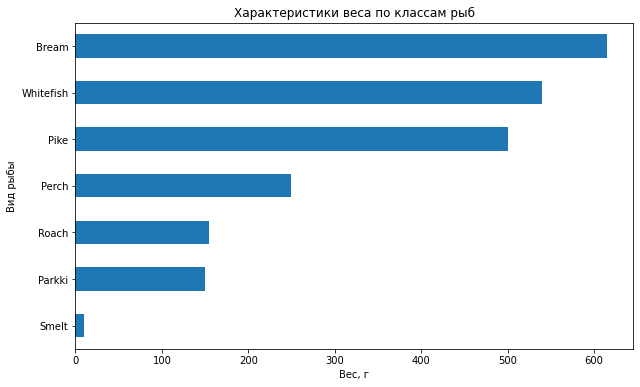

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))
train_df.groupby('Species')['Weight'].agg('median').sort_values().plot(kind='barh', ax=ax)
ax.set_title('Характеристики веса по классам рыб')
ax.set_xlabel('Вес, г')
ax.set_ylabel('Вид рыбы')

По графику видно, что вес некоторых рыб слабо отличается

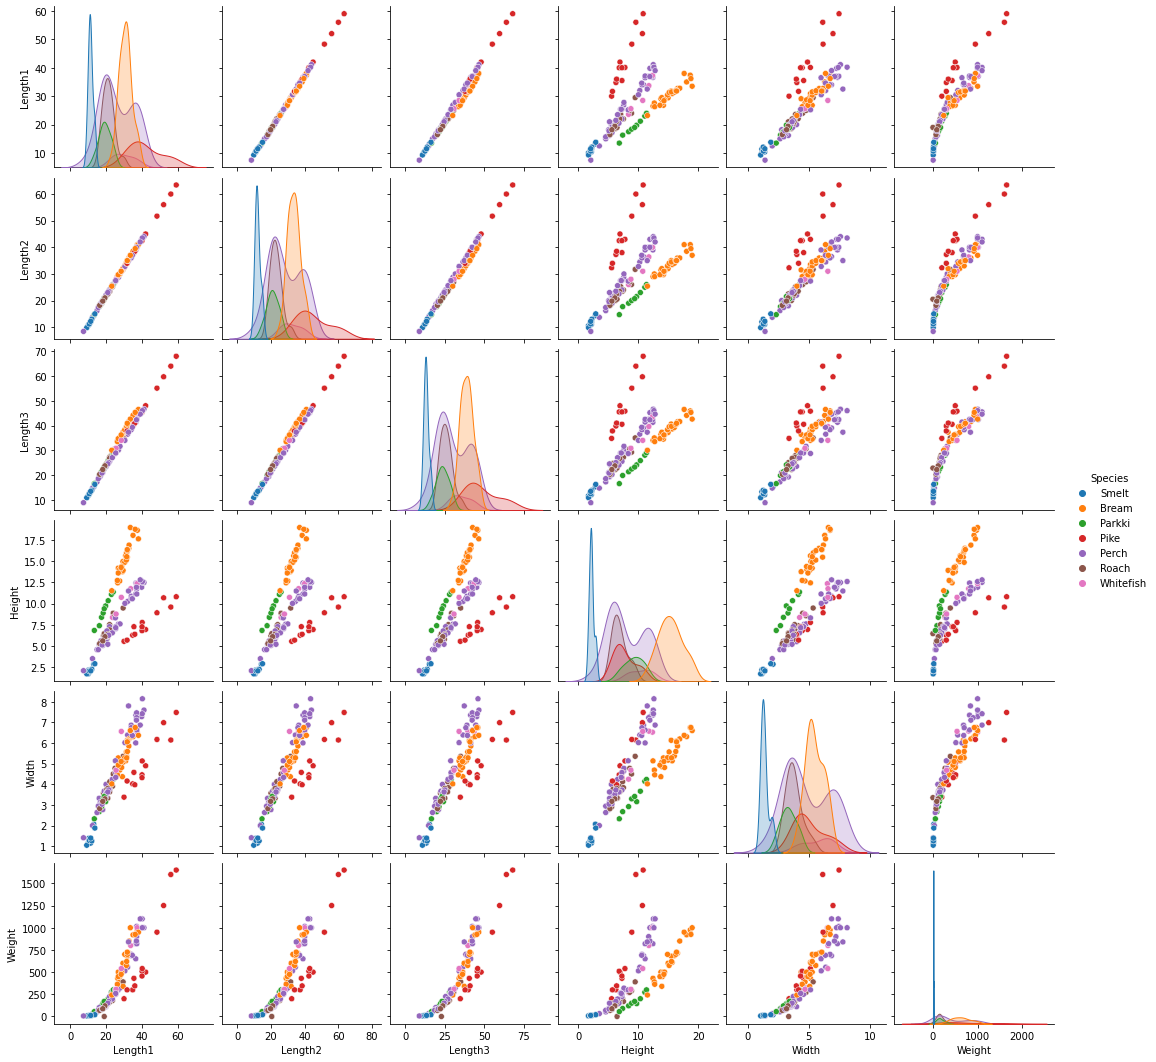

In [89]:
sns.pairplot(data=train_df, hue='Species')

На основании диаграмм рассеивания можно заметить выделяющиеся классы рыб. Также можно заметить, что между признаками существует средняя или сильная корреляция.

Text(0.5, 1.0, 'Корреляции между признаками и целевой переменной')

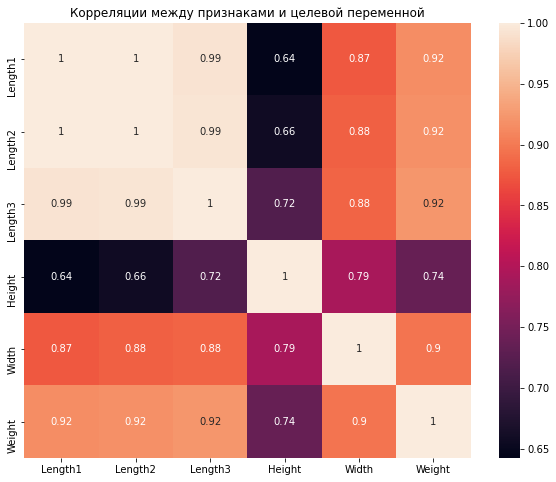

In [99]:
corr_table = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_table, annot=True)
plt.title('Корреляции между признаками и целевой переменной')

Признаки Length1, Length2, Length3 имеют между собой очень большую корреляцию, они взаимозависимы и будут мешать модели в процессе обучения, поэтому необходимо оставить из них только 1, например, Length3.

Остальные признаки можно оставить в том же виде. Они, как и предыдущие 3, имеют среднюю и сильную взаимосвязь с целевой переменной.

## Подготовка признаков

In [274]:
def prepare_features(data):
    ohe_values = pd.get_dummies(data[:, 0], drop_first=True).values 
    number_values = data[:, 3:]
    return np.hstack([ohe_values, number_values])

In [275]:
X_train = prepare_features(X_train)
X_test = prepare_features(X_test)

In [276]:
X_scaler = StandardScaler()
X_train[:, 6:] = X_scaler.fit_transform(X_train[:, 6:])
X_test[:, 6:] = X_scaler.transform(X_test[:, 6:])

In [277]:
y_train = y_train / 1000
y_test = y_test / 1000

In [278]:
X_train.shape, X_test.shape

((127, 9), (32, 9))

In [279]:
y_train.shape, y_test.shape

((127,), (32,))

### Модель с параметрами по умолчанию

In [303]:
ridge = Ridge().fit(X_train, y_train)
predicts = ridge.predict(X_test)
mse = mean_squared_error(y_test, predicts)
rmse = np.sqrt(mse)
print("RMSE: " + str(rmse))

RMSE: 0.09601916472804647


Как мы видим, модель без настройки гипперпараметров дает среднюю ошибку в 96 грамм

### Модель с лучшими параметрами

In [304]:
grid_searcher = GridSearchCV(
        estimator=Ridge(),
        param_grid=dict(
            alpha=np.linspace(0.01, 1, 10),
            fit_intercept=[True, False]
        ),
        cv=5
)

In [305]:
grid_searcher.fit(X_train, y_train)
predicts = ridge.predict(X_test)
mse = mean_squared_error(y_test, predicts)
rmse = np.sqrt(mse)
print("RMSE: " + str(rmse))

RMSE: 0.09601916472804647


In [306]:
grid_searcher.best_params_

{'alpha': 0.23, 'fit_intercept': True}

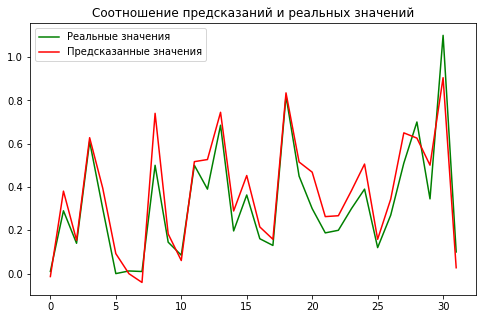

In [307]:
indexes = np.arange(0, 32)
plt.figure(figsize=(8, 5))
plt.title("Соотношение предсказаний и реальных значений")
plt.plot(indexes, y_test, c='g', label='Реальные значения')
plt.plot(indexes, predicts, c='r', label='Предсказанные значения')
plt.legend()

In [308]:
print("Число отрицательных значений предсказаний: " + str((predicts < 0).sum()))

Число отрицательных значений предсказаний: 3


Модель получает отрицательные значения для предсказанного веса, что критически неверно. Посмотрим на веса модели

In [310]:
print("Значение байеса: " + str(round(grid_searcher.best_estimator_.intercept_, 3)))
print("Значения коэффициентов: " + str([round(item, 3) for item in grid_searcher.best_estimator_.coef_]))

Значение байеса: 0.374
Значения коэффициентов: [0.112, 0.071, -0.218, 0.03, 0.312, 0.054, 0.414, 0.001, 0.028]


Как видим, модель переобучилась и уровень регуляризации для неё был слишком мал

### Модель без обучения байеса и большей степенью регуляризации

In [311]:
ridge = Ridge(alpha=0.5, fit_intercept=False).fit(X_train, y_train)
predicts = ridge.predict(X_test)
mse = mean_squared_error(y_test, predicts)
rmse = np.sqrt(mse)
print("RMSE: " + str(rmse))

RMSE: 0.08807435129806834


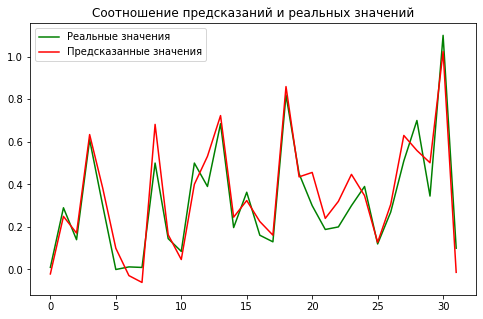

In [312]:
indexes = np.arange(0, 32)
plt.figure(figsize=(8, 5))
plt.title("Соотношение предсказаний и реальных значений")
plt.plot(indexes, y_test, c='g', label='Реальные значения')
plt.plot(indexes, predicts, c='r', label='Предсказанные значения')
plt.legend()

In [313]:
print("Число отрицательных значений предсказаний: " + str((predicts < 0).sum()))

Число отрицательных значений предсказаний: 4


In [314]:
print("Значение байеса: " + str(round(ridge.intercept_, 3)))
print("Значения коэффициентов: " + str([round(item, 3) for item in ridge.coef_]))

Значение байеса: 0.0
Значения коэффициентов: [0.336, 0.54, 0.382, 0.46, 0.784, 0.42, 0.35, 0.316, -0.122]


В отсутствие байеса большими весами стали обладать другие коэффициенты. Отрицательные результаты по-прежнему присутствуют. Попытаемся увеличить еще больше регуляризацию и посмотреть на результат

## Итоги

В результате обучения линейной регрессии с l2-регуляризацией удалось достигнуть средней ошибки в 88 грамм. При этом не тренировался байес и модель может выдавать отрицательные значения. Дальнейшая регуляризация позволит избежать отрицательных значений, но при этом значительно увеличится ошибка.

Возможно оказало влияние то, что признаки между собой имеют корреляцию выше средней